### 黄金-比特币持有比例

#### 一、引入相关库

In [73]:
import pandas as pd  
import numpy as np
import quandl   # 获取股票数据

from datetime import date
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

#### 二、导入数据

In [129]:
# 计算每日收益率，并丢弃缺失值
stock_price = pd.read_csv("temp.csv",index_col="Date")
# 打印前5行数据
print(stock_price.head())

           Bitcoin     Gold
Date                       
2016/9/12   609.67  1324.60
2016/9/13   610.92  1323.65
2016/9/14   608.82  1321.75
2016/9/15   610.38  1310.80
2016/9/16   609.11  1308.35


#### 计算涨跌幅

In [130]:

stock_return = stock_price.pct_change().dropna()

print(stock_return.head())

            Bitcoin      Gold
Date                         
2016/9/13  0.002050 -0.000717
2016/9/14 -0.003437 -0.001435
2016/9/15  0.002562 -0.008284
2016/9/16 -0.002081 -0.001869
2016/9/19  0.001773  0.004968


#### 设置组合权重(可以不写入文章)
这里的$w_{b} = 0.4$和$w_{g} = 0.6$  
是随机写的

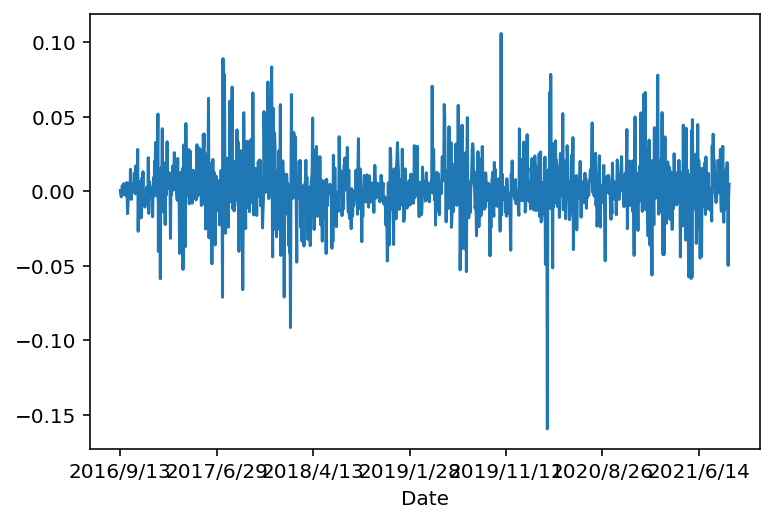

In [131]:
# 设置组合权重，存储为numpy数组类型
portfolio_weights = np.array([0.4,0.6])

# 将收益率数据拷贝到新的变量 stock_return 中，这是为了后续调用的方便
stock_return = stock_return.copy()

# 计算加权的股票收益
weighted_returns = stock_return.mul(portfolio_weights, axis=1)

# 计算投资组合的收益
stock_return['Portfolio'] = weighted_returns.sum(axis=1)

# 绘制组合收益随时间变化的图
stock_return.Portfolio.plot()
plt.show()

#### 涨跌幅累计图
$当前累计涨跌幅 = 当日之前所有涨跌幅之和$ 

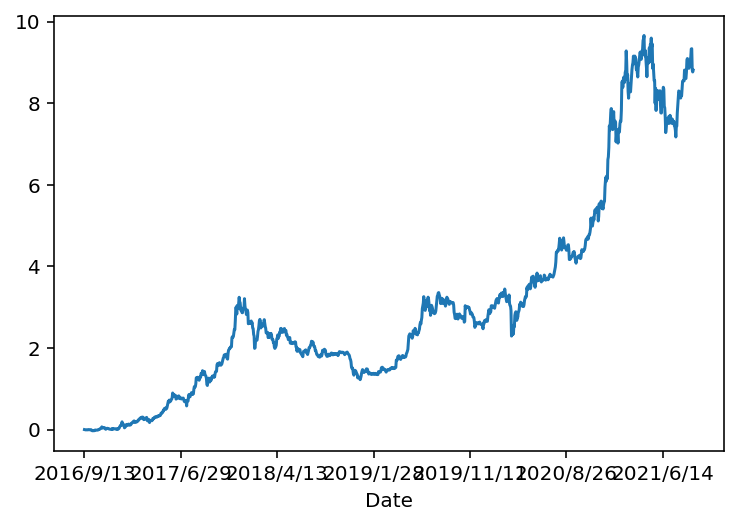

In [132]:
# 计算累积的组合收益，并绘图
CumulativeReturns = ((1+stock_return["Portfolio"]).cumprod()-1)
CumulativeReturns.plot()
plt.show()

#### 辅助函数，绘图曲线

In [133]:
# 累积收益曲线绘制函数
def cumulative_returns_plot(name_list):
    for name in name_list:
        CumulativeReturns = ((1+stock_return[name]).cumprod()-1)
        CumulativeReturns.plot(label=name)
    plt.legend()
    plt.show()

#### 权重设置方案1 - 平均权重 
$$
    w_{b} = w_{g} = 0.5 \\
    portfloio:随机权重收益 \\
    portfloio\_EW:平均权重收益
$$
图中黄线为平均权重的累计收益曲线  
蓝线为随机设置的收益曲线  
黄线比蓝线高，证明平均权重方案比随机取值效果好

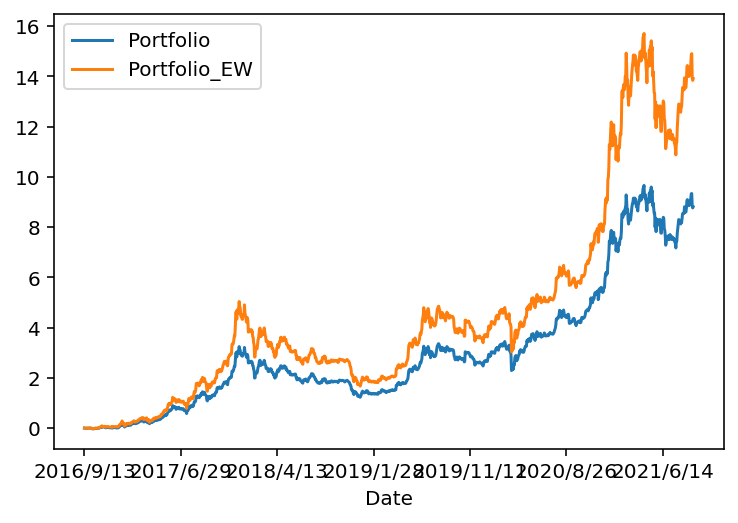

In [134]:
# 设置投资组合中股票的数目
numstocks = 2

# 平均分配每一项的权重
portfolio_weights_ew = np.array([1/numstocks]*numstocks+[0])

# 计算等权重组合的收益
stock_return['Portfolio_EW'] = stock_return.mul(portfolio_weights_ew, axis=1).sum(axis=1)

# 绘制累积收益曲线
cumulative_returns_plot(['Portfolio', 'Portfolio_EW'])

#### 投资品的相关系数矩阵
相关系数矩阵关于主对角线对称，表示两种投资品涨跌趋势的相关度，数值为正表示正相关，负表示负相关，0表示无关。

In [95]:
# 计算相关矩阵
correlation_matrix = stock_return.corr()

# 输出相关矩阵
print(correlation_matrix)

          Bitcoin      Gold
Bitcoin  1.000000  0.039866
Gold     0.039866  1.000000


#### 相关系数矩阵热图展示(较为美观)

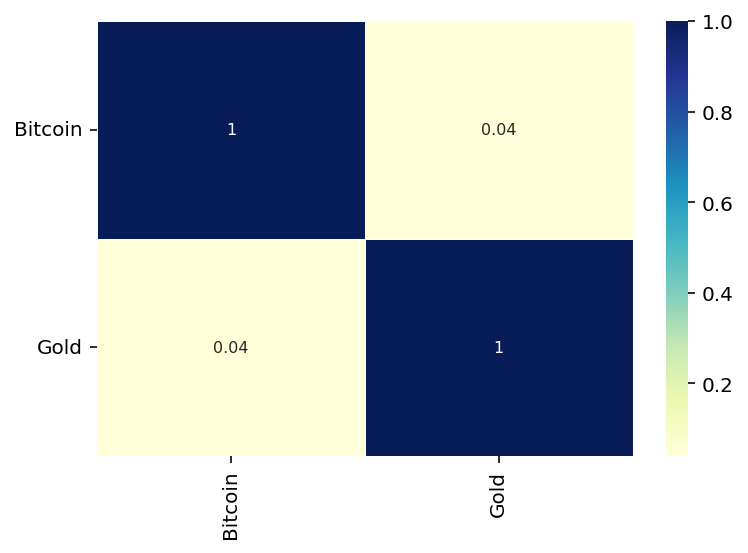

In [96]:
# 导入seaborn
import seaborn as sns

# 创建热图
sns.heatmap(correlation_matrix,
            annot=True,
            cmap="YlGnBu", 
            linewidths=0.3,
            annot_kws={"size": 8})

plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

#### 投资品的协方差矩阵
同样是关于主对角线的对称矩阵，反应了投资品价格的波动情况

In [97]:
# 计算协方差矩阵
cov_mat = stock_return.cov()

# 年化协方差矩阵
cov_mat_annual = cov_mat * 252

# 输出协方差矩阵
print(cov_mat_annual)

          Bitcoin      Gold
Bitcoin  0.590916  0.004193
Gold     0.004193  0.018716


#### 投资组合的标准差
投资组合的标准差反映了其波动情况，是衡量该组合风险的重要指标，，计算公式为:
$$
    σ = \sqrt(w^{t}·Σ·w)  
    w^{t}:权重转置  
    Σ:投资组合的协方差矩阵  
    w:投资组合权重  
$$

In [98]:
# 计算投资组合的标准差
portfolio_volatility = np.sqrt(np.dot(portfolio_weights.T, 
                                      np.dot(cov_mat_annual, portfolio_weights)))
print(portfolio_volatility)

0.32139836334601946


#### (重点)马科维兹的均值-方差分析法+有效边界模型确定投资组合
马科维茨（Markowitz）提出的投资组合理论被广泛用于组合选择和资产配置中。该理论中的均值-方差分析法和有效边界模型可用于寻找最优的投资组合。
这里使用蒙特卡洛模拟分析:
设
$$
Returns:收益率\\ 
Volatility:标准差\\  
w_{b}:比特币投资权重\\  
w_{g}:黄金投资权重\\  
$$
目标:  
随机生成合法的$(w_{b},w_{g})$，尝试遍历其所有可能
$$
(w_{b},w_{g}) -> (Volatility,Returns))
$$
下图模拟的蓝色散点图(点太多看起来想直线)即为所有可能的近似值

In [99]:
# 设置模拟的次数
number = 10000
ticker_list = ["Bitcoin","Gold"]
# 设置空的numpy数组，用于存储每次模拟得到的权重、收益率和标准差
random_p = np.empty((number, 4))
# 设置随机数种子，这里是为了结果可重复
np.random.seed(123)

# 循环模拟10000次随机的投资组合
for i in range(number):
    # 生成2个随机数，并归一化，得到一组随机的权重数据
    random2 = np.random.random(2)
    random_weight = random2 / np.sum(random2)
    
    # 计算年化平均收益率
    mean_return = stock_return.mul(random_weight, axis=1).sum(axis=1).mean()
    annual_return = (1 + mean_return)**252 - 1

    # 计算年化的标准差，也称为波动率
    random_volatility = np.sqrt(np.dot(random_weight.T, 
                                       np.dot(cov_mat_annual, random_weight)))

    # 将上面生成的权重，和计算得到的收益率、标准差存入数组random_p中
    random_p[i][:2] = random_weight
    random_p[i][2] = annual_return
    random_p[i][3] = random_volatility
    
# 将numpy数组转化成DataFrame数据框
RandomPortfolios = pd.DataFrame(random_p)
# 设置数据框RandomPortfolios每一列的名称
RandomPortfolios.columns = [ticker + "_weight" for ticker in ticker_list] + ['Returns', 'Volatility']
print(RandomPortfolios.head())

   Bitcoin_weight  Gold_weight   Returns  Volatility
0        0.708796     0.291204  1.324573    0.547895
1        0.291521     0.708479  0.474593    0.247679
2        0.629691     0.370309  1.132538    0.488698
3        0.588838     0.411162  1.039638    0.458347
4        0.550864     0.449136  0.956906    0.430308


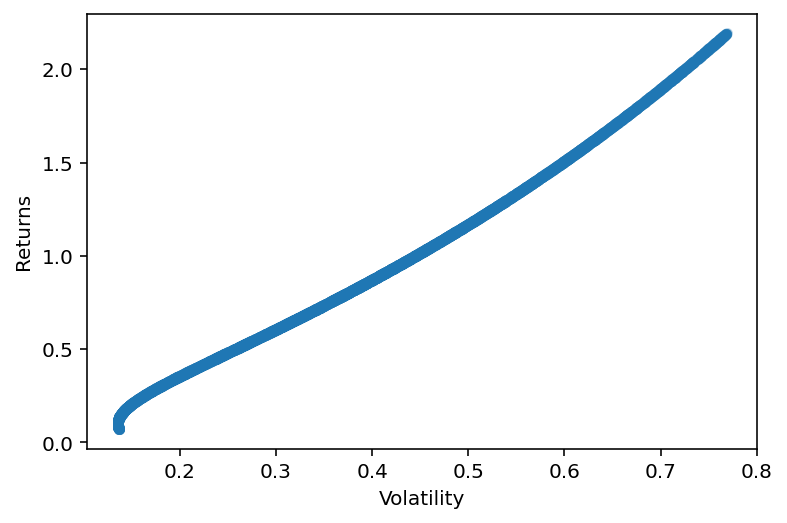

In [100]:
# 绘制散点图
RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
plt.show()

#### 权重配置方案2 最小风险
找出以上蒙特卡洛中模拟出的volatility标准差(表示风险)最小的值作为投资策略，一种稳健的方法，下图红色点为对应的权重值

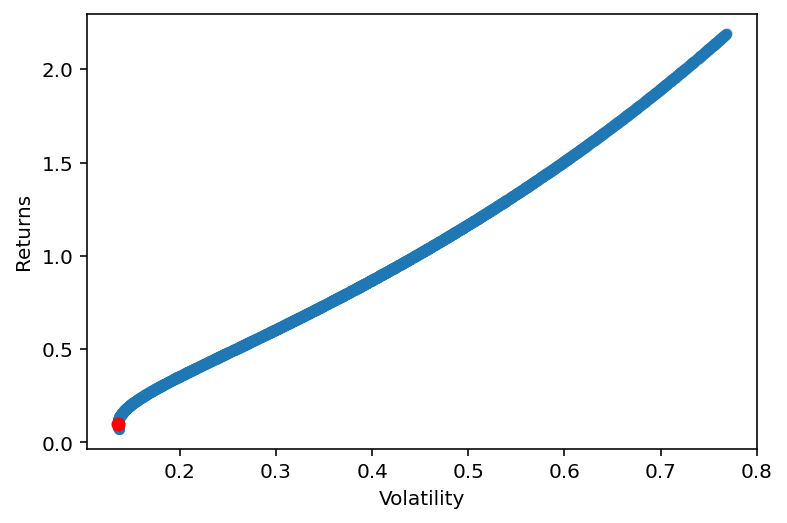

In [101]:
# 找到标准差最小数据的索引值
min_index = RandomPortfolios.Volatility.idxmin()

# 在收益-风险散点图中突出风险最小的点
RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
x = RandomPortfolios.loc[min_index,'Volatility']
y = RandomPortfolios.loc[min_index,'Returns']
plt.scatter(x, y, color='red')   
plt.show()

#### 夏普率投资
夏普比率计算的是，每承受一单位的总风险所产生的超额回报  
夏普率越高越好
$$
    Sharpe = \frac{R_{p} - R_{f}}{σ_{p}}
$$
$R_{p}$是预期回报率  
$R_{f}$是无风险利率   
$σ_{p}$是超额收益的标准差  
下图为各个模拟的散点的夏普率分布

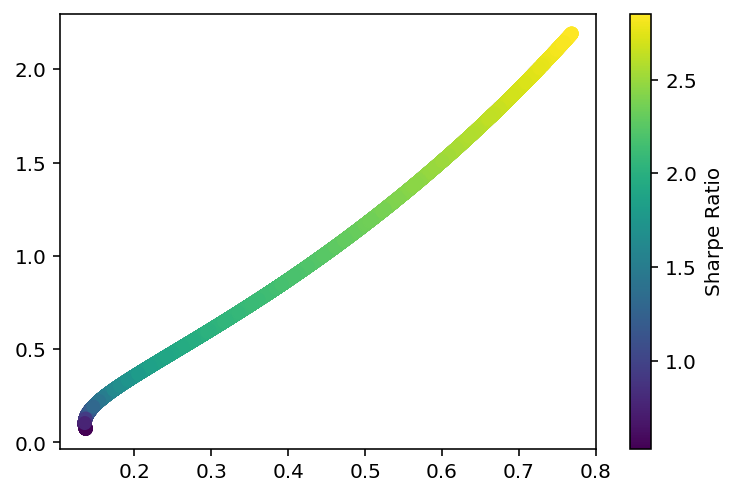

In [103]:
# 设置无风险回报率为0
risk_free = 0

# 计算每项资产的夏普比率
RandomPortfolios['Sharpe'] = (RandomPortfolios.Returns - risk_free)   \
                            / RandomPortfolios.Volatility

# 绘制收益-标准差的散点图，并用颜色描绘夏普比率
plt.scatter(RandomPortfolios.Volatility, RandomPortfolios.Returns, 
            c=RandomPortfolios.Sharpe)
plt.colorbar(label='Sharpe Ratio')
plt.show()


#### 选取夏普率最大的点的权值(下图红点)

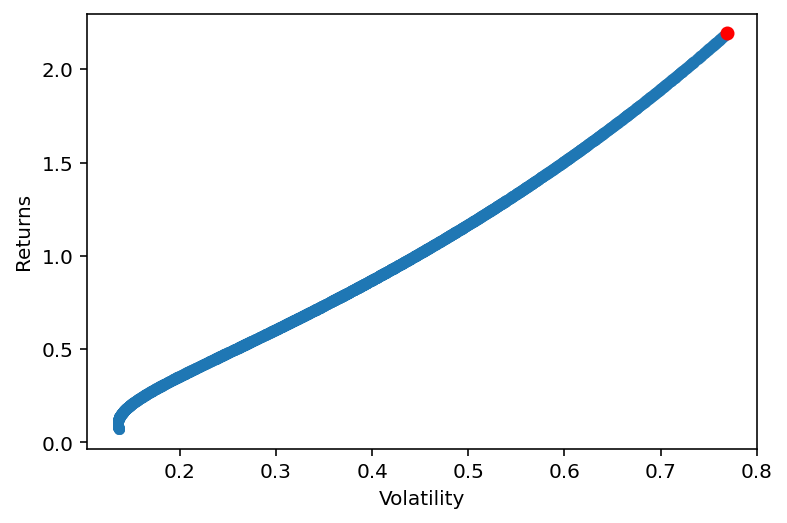

In [104]:
# 找到夏普比率最大数据对应的索引值
max_index = RandomPortfolios.Sharpe.idxmax()

# 在收益-风险散点图中突出夏普比率最大的点
RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
x = RandomPortfolios.loc[max_index,'Volatility']
y = RandomPortfolios.loc[max_index,'Returns']
plt.scatter(x, y, color='red')   
plt.show()

#### 绘制夏普率收益曲线(可以看下一节)

            Bitcoin      Gold  Portfolio  Portfolio_EW
Date                                                  
2016/9/13  0.002050 -0.000717   0.000390      0.000667
2016/9/14 -0.003437 -0.001435  -0.002236     -0.002436
2016/9/15  0.002562 -0.008284  -0.003946     -0.002861
2016/9/16 -0.002081 -0.001869  -0.001954     -0.001975
2016/9/19  0.001773  0.004968   0.003690      0.003371
...             ...       ...        ...           ...
2021/9/6   0.049465 -0.001152   0.019095      0.024157
2021/9/7   0.017546 -0.010677   0.000612      0.003434
2021/9/8  -0.111399 -0.008962  -0.049937     -0.060180
2021/9/9  -0.015612  0.001260  -0.005489     -0.007176
2021/9/10  0.006300  0.003551   0.004651      0.004926

[1264 rows x 4 columns]
            Bitcoin      Gold  Portfolio  Portfolio_EW  Portfolio_MSR
Date                                                                 
2016/9/13  0.002050 -0.000717   0.000390      0.000667       0.002050
2016/9/14 -0.003437 -0.001435  -0.002236     -0.00

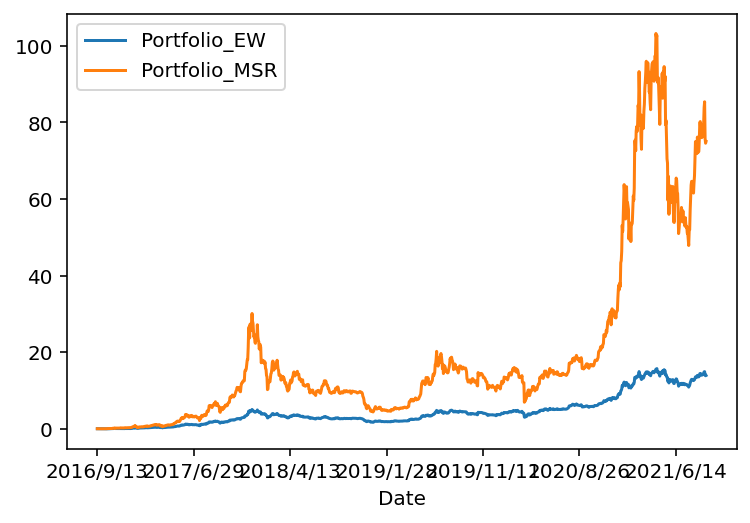

In [135]:
# 提取最大夏普比率组合对应的权重，并转化为numpy数组
MSR_weights = np.array(RandomPortfolios.iloc[max_index, 0:numstocks])
MSR_weights = np.append(MSR_weights,0.0)
MSR_weights = np.append(MSR_weights,0.0)
print(stock_return)
# 计算MSR组合的收益
stock_return['Portfolio_MSR'] = stock_return.mul(MSR_weights, axis=1).sum(axis=1)
print(stock_return)
# 绘制累积收益曲线
cumulative_returns_plot(['Portfolio_EW', 'Portfolio_MSR'])

#### 使用全局数据预测夏普最优投资收益曲线(仅做实例，写论文时可以写作用一定题目中范围数据测试)

#### 夏普最优投资计算的权值如下
由于长线(这里数据是全局)来看，比特币涨幅相当巨大，所以把钱全投这里比较明智，实际投资的每天都要跟新权值

In [139]:
print("Gold Weight: "+ str(MSR_weights[1]))
print("Bitcoin Weight: "+ str(MSR_weights[0]))
print("Cash Weight: "+ str(1 - MSR_weights[0] - MSR_weights[1]))


Gold Weight: 7.979175493917906e-05
Bitcoin Weight: 0.9999202082450608
Cash Weight: 3.890930546507354e-17


#### 各种权值配置收益曲线
$Portfolio:开始用的随便设置的权重收益$
$Portfolio_EW:平均权重配置收益$
$Portfolio_GMV:最小波动配置$
$Portfolio_MSR:夏普最优组合$
可见，随机权值配置效果最差，最小波动收益和平均配置曲线略高于随机，收益有所改善，夏普最优组合收益曲线远高于其他曲线，效果最好

            Bitcoin      Gold  Portfolio  Portfolio_EW  Portfolio_MSR
Date                                                                 
2016/9/13  0.002050 -0.000717   0.000390      0.000667       0.002050
2016/9/14 -0.003437 -0.001435  -0.002236     -0.002436      -0.003437
2016/9/15  0.002562 -0.008284  -0.003946     -0.002861       0.002561
2016/9/16 -0.002081 -0.001869  -0.001954     -0.001975      -0.002081
2016/9/19  0.001773  0.004968   0.003690      0.003371       0.001773


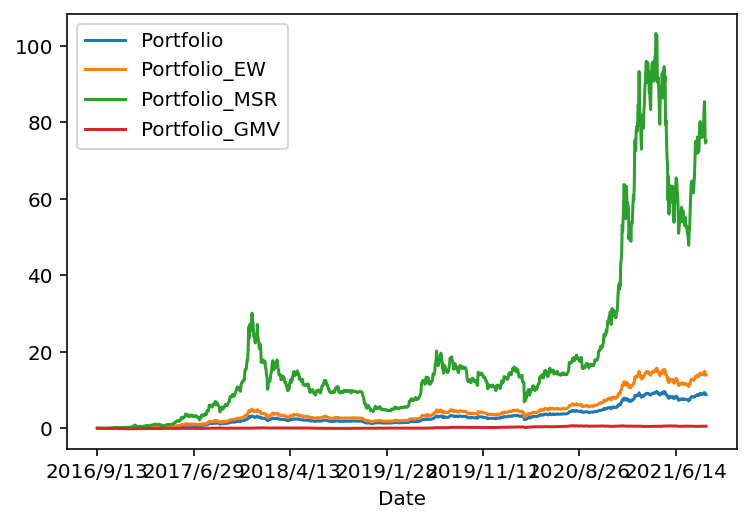

In [141]:
# 提取最小波动组合对应的权重, 并转换成Numpy数组
GMV_weights = np.array(RandomPortfolios.iloc[min_index, 0:numstocks])
GMV_weights = np.append(GMV_weights,0.0)
GMV_weights = np.append(GMV_weights,0.0)
GMV_weights = np.append(GMV_weights,0.0)

print(stock_return.head())
# 计算GMV投资组合收益
stock_return['Portfolio_GMV'] = stock_return.mul(GMV_weights, axis=1).sum(axis=1)

# 绘制累积收益曲线
cumulative_returns_plot(['Portfolio','Portfolio_EW', 'Portfolio_MSR', 'Portfolio_GMV'])

最后说明，本建模使用蒙特卡洛模拟实现的夏普最优权重配置，在每个交易日依据先前交易日的历史数据计算当前最优权值，加入后续投资策略于模拟中使用，就是每天都要算权值，动态更新